# Notebook for generating Figures 10 and 11 in Traill et al. (2025) 

Reproduces Figures 10 and 11, processes CMIP6 model output. 


Output for each earth system model historical simulation is for the period 1950-2014. Details and references to each model output can be found in Rohr et al. (2023) https://doi.org/10.1038/s43247-023-00871-w

Christopher Traill: christopher.traill@utas.edu.au

https://github.com/cdtraill

November 2025

Latest update: 12th December 2025

## Readme 

The code presented here can be simply adapated to any ocean region by changing the spatial domain. Note that in regions where the subtropical front doesn't occur, derviations of the subtropical front will drop out and potentially cause code errors. These sections can be easily omitted by commenting out sections. 

## Data sets: 

For full details, see the Methods of Traill et al. (2025) "Towards Constraining the Drivers of Variability and Trends in Subantarctic Productivity"


CMIP6 model output was sourced from the Earth System Grid Federation (Table 2), with model selection restricted to those with outputs saved for gridded temperature at depth in order to derive STF locations (Table 1). Trends in spatial mean monthly NPP, MLD, SST and STF mean latitude anomalies for remote sensing algorithms (1998-2022), PISCES-Quota-Fe (1975-2022) and historical CMIP6 model (1950 – 2014) were determined using an ordinary least squares linear regression. 

References to each model and model output host server are provided in Traill et al (2025). 


## Load dependencies and set path

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, TwoSlopeNorm
import matplotlib.cm as cm
from matplotlib.dates import DateFormatter
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d
from scipy.interpolate import griddata
from scipy import stats
from scipy.stats import linregress
import statsmodels.api as sm
import seaborn as sns
import pandas as pd 
import cartopy
from geopy.distance import geodesic
from geopy import Point
import gsw
import cartopy.crs as ccrs 
import cartopy.feature as cfeature 
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import netCDF4 as nc
import xarray as xr
import owslib
import os
import cftime
import sys
import glob
import calendar
import string

In [2]:
path = '/Users/christoph/Library/CloudStorage/OneDrive-UniversityofTasmania/Research/PhD Project/Theme 3 Model Obs/CMIP6 Output/'
os.chdir(path)

# Figure 10: 

## Calculate key metrics for each model run

In [13]:
R = 6.371e6
lat_range = slice(-49, -45)
lon_range = slice(140, 150)

def deg2rad(deg): return np.radians(deg)

def area_between(lat1, lat2, lon_width_deg):
    lat1_rad = deg2rad(lat1)
    lat2_rad = deg2rad(lat2)
    lon_width_rad = deg2rad(lon_width_deg)
    return R**2 * np.abs(np.sin(lat2_rad) - np.sin(lat1_rad)) * lon_width_rad

def extract_stf_latitudes(ds):
    temp_100 = ds['thetao'].mean(dim='depth')
    lat = temp_100['lat']
    lon = temp_100['lon']
    years = temp_100['year'].values
    months = temp_100['month'].values

    df_list = []

    for year in years:
        for month in months:
            try:
                data2d = temp_100.sel(year=year, month=month).transpose('lat', 'lon').values
                if np.isnan(data2d).all():
                    continue            
                
                cs = plt.contour(lon, lat, data2d, levels=[11.0])
                lon_list, lat_list = [], []
                # Extract contour points directly
                for segs in cs.allsegs:   # each contour level (here just one: 11°C)
                    for seg in segs:      # each continuous line segment
                        lon_list.append(seg[:, 0])
                        lat_list.append(seg[:, 1])
                # Remove the entire contour set from the axes
                plt.close()
                cs.remove()
                                
            except Exception:
                continue

            if not lon_list:
                continue

            all_lons = np.concatenate(lon_list)
            all_lats = np.concatenate(lat_list)
            sort_idx = np.argsort(all_lons)
            sorted_lons = all_lons[sort_idx]
            sorted_lats = all_lats[sort_idx]

            unique_lons = np.linspace(sorted_lons.min(), sorted_lons.max(), num=30)
            mean_lats = []
            for lon_val in unique_lons:
                mask = np.abs(sorted_lons - lon_val) < 0.5
                mean_lats.append(np.mean(sorted_lats[mask]) if np.any(mask) else np.nan)

            valid = ~np.isnan(mean_lats)
            if np.any(valid):
                interp_mean = interp1d(unique_lons[valid], np.array(mean_lats)[valid], kind='linear', fill_value='extrapolate')
                mean_lats = interp_mean(unique_lons)

            df_list.append(pd.DataFrame({
                'year': year,
                'month': month,
                'longitude': unique_lons,
                'mean_latitude': mean_lats
            }))

    return pd.concat(df_list, ignore_index=True)

def compute_area_coverage(df_stf):
    df_stf['timestep'] = df_stf['year'] * 100 + df_stf['month']
    results = []
    for timestep, group in df_stf.groupby('timestep'):
        group = group.sort_values('longitude')
        box_group = group[(group['longitude'] >= 140) & (group['longitude'] <= 150)].copy()
        if box_group.empty:
            results.append({'timestep': timestep, 'year': group['year'].iloc[0], 
                            'month': group['month'].iloc[0],
                            'percent_covered': np.nan, 'mean_latitude': np.nan})
            continue

        # Clip STF to bounding box
        box_group['stf_clipped'] = np.clip(box_group['mean_latitude'], -49, -45)

        lon_vals = box_group['longitude'].values
        lat_vals = box_group['stf_clipped'].values
        dlon = np.mean(np.diff(lon_vals)) if len(lon_vals) > 1 else 10

        # Compute area for each segment (already in m^2)
        covered_areas = np.array([area_between(lat, -45, dlon) for lat in lat_vals])
        total_covered_area = np.nansum(covered_areas)
        total_box_area = area_between(-49, -45, 10)
        percent_covered = (total_covered_area / total_box_area) * 100

        # Area-weighted mean latitude
        if np.nansum(covered_areas) > 0:
            mean_latitude = np.nansum(lat_vals * covered_areas) / np.nansum(covered_areas)
        else:
            mean_latitude = np.nan

        results.append({
            'timestep': timestep,
            'year': group['year'].iloc[0],
            'month': group['month'].iloc[0],
            'percent_covered': percent_covered,
            'mean_latitude': mean_latitude
        })

    return pd.DataFrame(results)

def extract_npp_stats_monthly(ds, df_area_coverage, model_name=None):
    ds_subset = ds.sel(lat=lat_range, lon=lon_range)
    
    out = []
    missing_vars = []

    # Compute area weights (cosine of latitude)
    lat_rad = np.deg2rad(ds_subset['lat'])
    weights = np.cos(lat_rad)
    # Normalize weights along latitude
    weights /= weights.mean(dim='lat')

    # Weighted mean for each variable if it exists
    if 'npp' in ds_subset:
        monthly_mean_npp = (ds_subset['npp'] * weights).mean(dim=['lon', 'lat'])
    else:
        monthly_mean_npp = None
        missing_vars.append('npp')
        
    if 'sst' in ds_subset:
        monthly_mean_sst = (ds_subset['sst'] * weights).mean(dim=['lon', 'lat'])
    else:
        monthly_mean_sst = None
        missing_vars.append('sst')
        
    if 'mld' in ds_subset:
        monthly_mean_mld = (ds_subset['mld'] * weights).mean(dim=['lon', 'lat'])
    else:
        monthly_mean_mld = None
        missing_vars.append('mld')
    
    if missing_vars:
        print(f"⚠️ Skipping missing variable(s) for model {model_name or '[unknown model]'}: {', '.join(missing_vars)}")

    for year in np.unique(df_area_coverage['year']):
        for month in range(1, 13):
            mean_npp = monthly_mean_npp.sel(year=year, month=month).item() if monthly_mean_npp is not None else np.nan
            mean_sst = monthly_mean_sst.sel(year=year, month=month).item() if monthly_mean_sst is not None else np.nan
            mean_mld = monthly_mean_mld.sel(year=year, month=month).item() if monthly_mean_mld is not None else np.nan

            # Extract area coverage info
            row = df_area_coverage[
                (df_area_coverage['year'] == year) &
                (df_area_coverage['month'] == month)
            ]
            if not row.empty:
                percent_covered = row['percent_covered'].values[0]
                mean_lat = row['mean_latitude'].values[0]
            else:
                percent_covered = np.nan
                mean_lat = np.nan

            out.append({
                'year': year,
                'month': month,
                'mean_npp': mean_npp,
                'mean_sst': mean_sst,
                'mean_mld': mean_mld,
                'percent_covered': percent_covered,
                'mean_latitude': mean_lat
            })

    return pd.DataFrame(out)

all_model_dfs = []
model_labels = []

model_files = ["GFDL-ESM4_temp_npp_subset.nc",
            "ACCESS_ESM1.5_temp_npp_subset.nc", 
               "CanESM5-CanOE_temp_npp_subset.nc",
               "CanESM5-CMOC_temp_npp_subset.nc",
               "CESM2_temp_npp_subset.nc",
               "CMCC-ESM2_temp_npp_subset.nc",
               "CNRM-ESM2-1_temp_npp_subset.nc",
               "IPSL-CM6A_temp_npp_subset.nc"]

for i, file in enumerate(model_files):
    progress = (i + 1) / len(model_files) * 100
    model_name = os.path.basename(file).replace('_temp_npp_subset.nc', '')
    print(f"\nProcessing model {i + 1}/{len(model_files)} ({progress:.2f}%) - {model_name}")
    
    ds = xr.open_dataset(file)
    df_stf = extract_stf_latitudes(ds)
    df_area_coverage = compute_area_coverage(df_stf)
    df_model = extract_npp_stats_monthly(ds, df_area_coverage, model_name=model_name)
    
    df_model['model'] = model_name
    all_model_dfs.append(df_model)
    model_labels.append(model_name)
    
    ds.close()

df_all_models_monthly = pd.concat(all_model_dfs, ignore_index=True)
print('Monthly processing complete.')


Processing model 1/8 (12.50%) - GFDL-ESM4
⚠️ Skipping missing variable(s) for model GFDL-ESM4: sst, mld

Processing model 2/8 (25.00%) - ACCESS_ESM1.5

Processing model 3/8 (37.50%) - CanESM5-CanOE

Processing model 4/8 (50.00%) - CanESM5-CMOC

Processing model 5/8 (62.50%) - CESM2

Processing model 6/8 (75.00%) - CMCC-ESM2

Processing model 7/8 (87.50%) - CNRM-ESM2-1

Processing model 8/8 (100.00%) - IPSL-CM6A
Monthly processing complete.


## Plot Figure 10: 

Plot model time series with trends

/var/folders/dk/4pyn7w4102bfzscb0m9606zw0000gn/T/ipykernel_7182/2894923938.py:80: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = model_fit.params[1]
/var/folders/dk/4pyn7w4102bfzscb0m9606zw0000gn/T/ipykernel_7182/2894923938.py:81: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pval = model_fit.pvalues[1]
/var/folders/dk/4pyn7w4102bfzscb0m9606zw0000gn/T/ipykernel_7182/2894923938.py:80: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

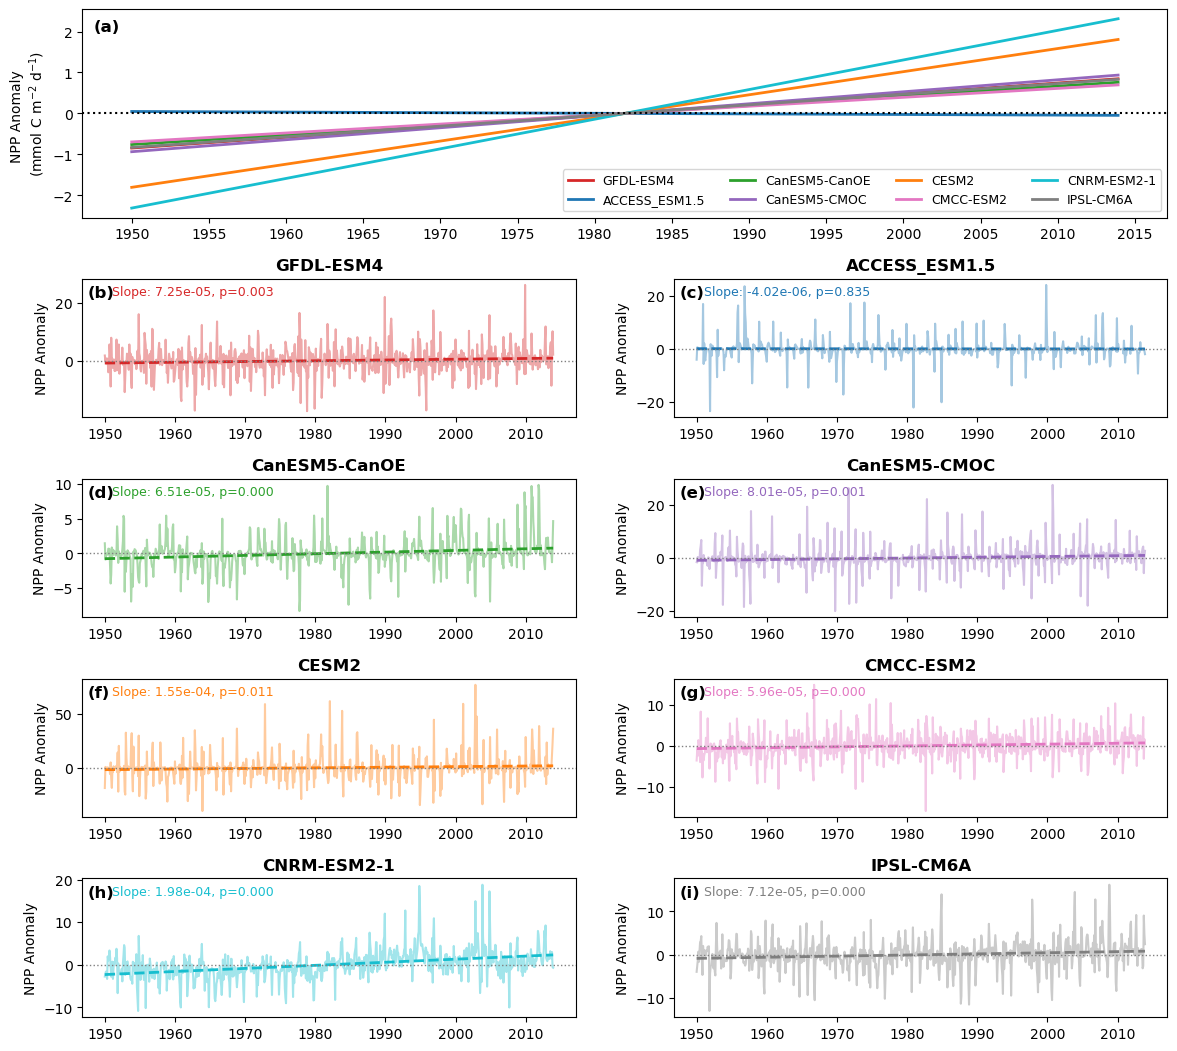

In [14]:
def deseasonalize(df, value_col, group_cols=['model']):
    # Monthly climatology (e.g., mean January, mean February, etc.) per model
    climatology = (
        df.groupby(group_cols + ['month'])[value_col]
        .mean()
        .reset_index()
        .rename(columns={value_col: 'climatology'})
    )
    
    # Merge back to original dataframe
    df_merged = pd.merge(df, climatology, on=group_cols + ['month'], how='left')
    
    # Calculate anomaly
    df_merged[f'{value_col}_anom'] = df_merged[value_col] - df_merged['climatology']
    
    return df_merged.drop(columns=['climatology'])

df_all_models_anom = df_all_models_monthly.copy()

for var in ['mean_npp', 'mean_sst', 'mean_mld', 'percent_covered', 'mean_latitude']:
    df_all_models_anom = deseasonalize(df_all_models_anom, var)

# Convert to datetime
df_all_models_anom['date'] = pd.to_datetime({
    'year': df_all_models_anom['year'],
    'month': df_all_models_anom['month'],
    'day': 1
})

models = df_all_models_anom['model'].unique()
colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:purple',
          'tab:orange', 'tab:pink', 'tab:cyan', 'tab:gray']
color_map = dict(zip(models, colors))

# Set up GridSpec layout
fig = plt.figure(figsize=(14, 12))
gs = gridspec.GridSpec(nrows=5, ncols=2, height_ratios=[1.5, 1, 1, 1, 1], hspace=0.4)

# ----- Top panel: overlayed trends -----
ax_top = fig.add_subplot(gs[0, :])
for i, model in enumerate(models):
    df_model = df_all_models_anom[df_all_models_anom['model'] == model].copy()
    df_model['time_numeric'] = (df_model['date'] - df_model['date'].min()).dt.days
    x = sm.add_constant(df_model['time_numeric'])
    model_fit = sm.OLS(df_model['mean_npp_anom'], x, missing='drop').fit()
    trend = model_fit.predict(x)
    
    ax_top.plot(df_model['date'], trend, label=model, color=color_map[model], linewidth=2)
    #ax_top.plot(df_model['date'], df_model['mean_npp_anom'], color=color_map[model], alpha=0.3)

ax_top.axhline(0, color='k', linestyle=':')
#ax_top.set_title("Deseasonalized NPP Anomaly Trends (All Models)", fontsize=13, fontweight='bold')
ax_top.set_ylabel("NPP Anomaly \n(mmol C m$^{-2}$ d$^{-1}$)")
ax_top.legend(ncol=4, fontsize=9, loc='lower right')
ax_top.xaxis.set_major_locator(mdates.YearLocator(5))
ax_top.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax_top.text(0.01, 0.95, "(a)", transform=ax_top.transAxes,
            fontsize=12, fontweight='bold', va='top', ha='left')

# ----- Individual model panels -----
for i, model in enumerate(models):
    row = i // 2 + 1  # start from row 1 since row 0 is the top plot
    col = i % 2
    ax = fig.add_subplot(gs[row, col])
    df_model = df_all_models_anom[df_all_models_anom['model'] == model].copy()
    df_model['time_numeric'] = (df_model['date'] - df_model['date'].min()).dt.days

    panel_label = f"({string.ascii_lowercase[i + 1]})"
    ax.text(0.01, 0.95, panel_label, transform=ax.transAxes,
             fontsize=12, fontweight='bold', va='top', ha='left')
    
    # Plot NPP anomaly and trend
    sns.lineplot(data=df_model, x='date', y='mean_npp_anom', ax=ax,
                 color=color_map[model], alpha=0.4)
    x = sm.add_constant(df_model['time_numeric'])
    model_fit = sm.OLS(df_model['mean_npp_anom'], x, missing='drop').fit()
    trend = model_fit.predict(x)
    ax.plot(df_model['date'], trend, color=color_map[model], linestyle='--', linewidth=2)

    slope = model_fit.params[1]
    pval = model_fit.pvalues[1]
    ax.text(0.06, 0.88, f"Slope: {slope:.2e}, p={pval:.3f}",
            transform=ax.transAxes, fontsize=9, color=color_map[model])

    ax.axhline(0, color='gray', linestyle=':', linewidth=1)
    ax.set_title(model, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('NPP Anomaly')
    ax.xaxis.set_major_locator(mdates.YearLocator(10))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Final touches
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()


# Figure 11: 
Bootstrap CMIP 6 Historical NPP, MLD, SST and STF position. 

## Set high and low NPP year filters

In [7]:
annual_npp = (df_all_models_monthly.groupby(['model', 'year'])['mean_npp'].sum().reset_index(name='annual_npp'))

model_npp_years = {}

for model_name, group in annual_npp.groupby('model'):
    sorted_group = group.sort_values('annual_npp', ascending=False)

    max_years = sorted_group.head(5)['year'].tolist()
    min_years = sorted_group.tail(5)['year'].tolist()

    # Store in dictionary with consistent naming
    key_prefix = model_name.lower().replace("-", "_").replace(".", "").replace(" ", "_")
    model_npp_years[f"max_{key_prefix}_npp_years"] = max_years
    model_npp_years[f"min_{key_prefix}_npp_years"] = min_years

## Parallel (multi-core) bootstrap processing: define pickable bootstrap function

In [15]:
with open("bootstrap_utils.py", "a") as f:
    f.write("""

import os
import numpy as np
import pandas as pd

def bootstrap_cmip_df(df, high_years, low_years, n_iter=10000, seed=None):
    
    #Perform bootstrap analysis on multiple variables in a DataFrame.
    #
    #Parameters:
    #    df (DataFrame): Must include 'year', 'month', and variable columns.
    #    high_years (list): High productivity years.
    #    low_years (list): Low productivity years.
    #    n_iter (int): Number of bootstrap iterations.
    #    seed (int): Random seed for reproducibility.
    #
    #Returns:
    #    dict: {var_name: (delta_obs_series, p_val_series)} for each variable
    
    rng = np.random.default_rng(seed)
    result = {}

    # Identify variable columns (everything except year and month)
    variable_cols = ['mean_npp', 'mean_sst', 'mean_mld', 'mean_latitude']

    for var in variable_cols:
        df_high = df[df['year'].isin(high_years)][['month', var]].copy()
        df_low = df[df['year'].isin(low_years)][['month', var]].copy()

        # Observed delta
        delta_obs = df_high.groupby('month')[var].mean() - df_low.groupby('month')[var].mean()

        # Bootstrap
        all_years = df['year'].unique()
        boot_deltas = []

        for _ in range(n_iter):
            sample_high = rng.choice(high_years, size=len(high_years), replace=False)
            remaining = np.setdiff1d(all_years, sample_high)
            sample_low = rng.choice(remaining, size=len(low_years), replace=False)

            boot_high = df[df['year'].isin(sample_high)].groupby('month')[var].mean()
            boot_low = df[df['year'].isin(sample_low)].groupby('month')[var].mean()

            boot_deltas.append(boot_high - boot_low)

        boot_deltas = pd.DataFrame(boot_deltas)

        # Compute p-values
        p_vals = (np.abs(boot_deltas) >= np.abs(delta_obs)).sum() / n_iter

        # Store results for this variable
        result[var] = (delta_obs, p_vals)

    return result


def run_single_model(model, model_npp_years, df_all_models_monthly, variables, bootstrap_cmip_df):
    
    #Wrapper for parallel bootstrap per model.
    #Defined here so ProcessPoolExecutor can pickle it.
    
    key_prefix = model.lower().replace("-", "_").replace(".", "")
    high_years = model_npp_years[f"max_{key_prefix}_npp_years"]
    low_years = model_npp_years[f"min_{key_prefix}_npp_years"]

    df_model = df_all_models_monthly[df_all_models_monthly["model"] == model]

    print(f"🔹 Starting bootstrap for {model} on PID {os.getpid()}")

    result = bootstrap_cmip_df(df_model[["year", "month"] + variables], high_years, low_years)

    print(f"✅ Finished {model} on PID {os.getpid()}")
    return model, result
    
""")


In [16]:
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm
import os

sys.path.append("/Users/christoph/Library/CloudStorage/OneDrive-UniversityofTasmania/Research/PhD Project/Theme 3 Model Obs/CMIP6 Output")
import bootstrap_utils
from bootstrap_utils import run_single_model, bootstrap_cmip_df

num_cpus = 8
bootstrap_results = {}
variables = ['mean_npp', 'mean_mld', 'mean_sst', 'mean_latitude']

futures = []
with ProcessPoolExecutor(max_workers=num_cpus) as executor:
    for model in models:
        futures.append(
            executor.submit(
                run_single_model,
                model,
                model_npp_years,
                df_all_models_monthly,
                variables,
                bootstrap_cmip_df
            )
        )

    for future in tqdm(as_completed(futures), total=len(futures), desc="Bootstrapping models", unit="model"):
        try:
            model, result = future.result()
            bootstrap_results[model] = result
        except Exception as e:
            print(f"⚠️ Skipping model due to error: {e}")

print("✅ All bootstraps complete.")

Bootstrapping models: 100%|██████████| 8/8 [00:34<00:00,  4.37s/model]

🔹 Starting bootstrap for CanESM5-CanOE on PID 7250
✅ Finished CanESM5-CanOE on PID 7250
🔹 Starting bootstrap for ACCESS_ESM1.5 on PID 7249
✅ Finished ACCESS_ESM1.5 on PID 7249
🔹 Starting bootstrap for CanESM5-CMOC on PID 7252
✅ Finished CanESM5-CMOC on PID 7252
🔹 Starting bootstrap for GFDL-ESM4 on PID 7251
✅ Finished GFDL-ESM4 on PID 7251
🔹 Starting bootstrap for IPSL-CM6A on PID 7256
✅ Finished IPSL-CM6A on PID 7256
🔹 Starting bootstrap for CNRM-ESM2-1 on PID 7255
✅ Finished CNRM-ESM2-1 on PID 7255
🔹 Starting bootstrap for CMCC-ESM2 on PID 7254
✅ Finished CMCC-ESM2 on PID 7254
🔹 Starting bootstrap for CESM2 on PID 7253
✅ Finished CESM2 on PID 7253
✅ All bootstraps complete.


## Arrange dataframe

In [17]:
# Flatten results into a long DataFrame
plot_data = []

for model, results in bootstrap_results.items():
    for variable, (delta_obs, p_vals) in results.items():
        for month in delta_obs.index:
            delta = delta_obs.loc[month]
            pval = p_vals.loc[month]
            plot_data.append({
                'model': model,
                'variable': variable,
                'month': month,
                'delta': delta,
                'p_val': pval
            })

df = pd.DataFrame(plot_data)

# Normalize delta per variable per models
#df['delta_norm'] = df.groupby(['model', 'variable'])['delta'].transform(lambda x: (x - x.mean()) / x.std())

# Normalize delta variable across all models
df['delta_norm'] = df.groupby('variable')['delta'].transform(lambda x: (x - 0) / x.std())

## Figure 11: Plot

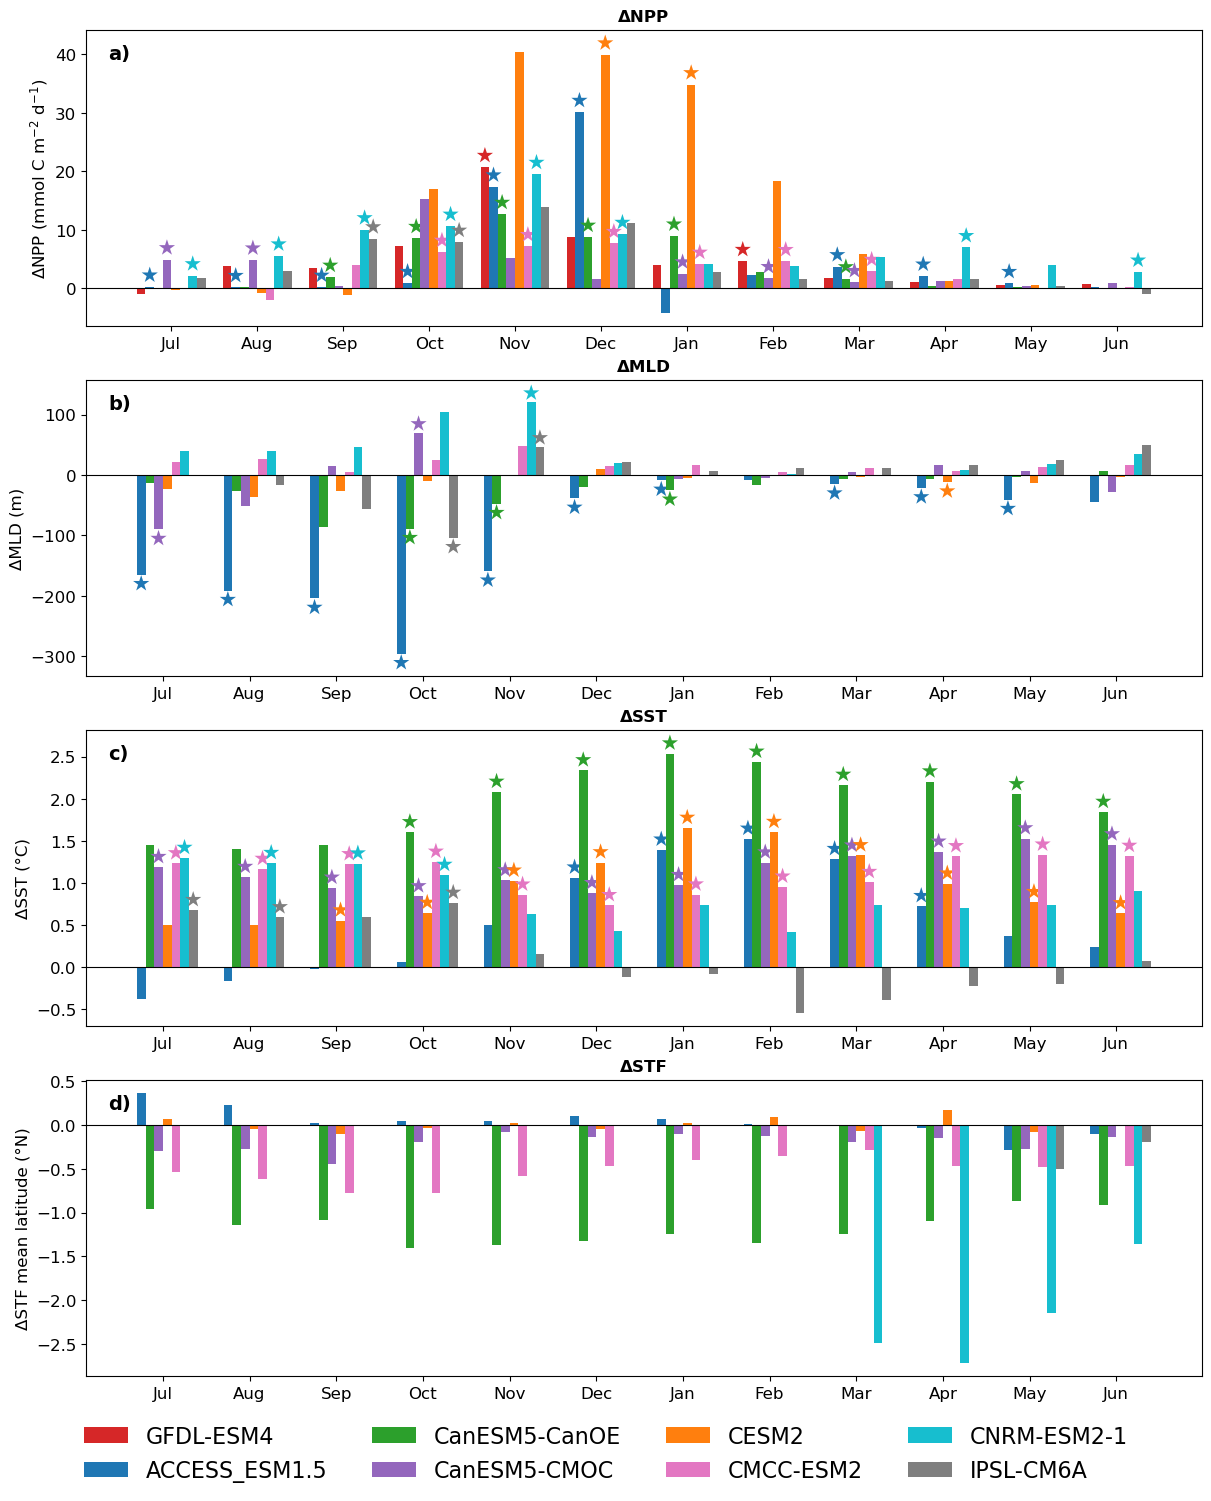

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# --- Setup ---
npp_models = ['GFDL-ESM4', 'ACCESS_ESM1.5', 'CanESM5-CanOE', 'CanESM5-CMOC', 'CESM2', 'CMCC-ESM2', 'CNRM-ESM2-1', 'IPSL-CM6A']  # These are your group names
colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:purple', 'tab:orange', 'tab:pink', 'tab:cyan', 'tab:gray']
color_map = dict(zip(npp_models, colors))

signif_threshold = 0.05
groups = npp_models
variables = ['mean_npp', 'mean_mld', 'mean_sst', 'mean_latitude']

bar_width = 0.8 / len(groups)
months_orig = np.arange(1, 13)

def circshift_months(df_var, shift=6):
    shifted_months = ((months_orig - 1 + shift) % 12) + 1
    month_map = dict(zip(months_orig, shifted_months))
    df_var = df_var.copy()
    df_var['month_shifted'] = df_var['month'].map(month_map)
    return df_var.sort_values('month_shifted')

units_map = {
    'mean_npp': 'ΔNPP (mmol C m$^{-2}$ d$^{-1}$)', 
    'mean_mld': 'ΔMLD (m)',
    'mean_sst': 'ΔSST (°C)',
    'mean_latitude': 'ΔSTF mean latitude (°N)',
}
titles_map = {
    'mean_npp': 'ΔNPP',
    'mean_mld': 'ΔMLD',
    'mean_sst': 'ΔSST',
    'mean_latitude': 'ΔSTF',
}

# --- Plot ---
fig, axs = plt.subplots(4, 1, figsize=(12, 14), constrained_layout=True)
axs = axs.flatten()


for i, ax in enumerate(axs):
    ax.text(
        0.02, 0.95,
        f"{string.ascii_lowercase[i]})",
        transform=ax.transAxes,
        fontsize=14,
        fontweight='bold',
        va='top'
    )

for i, var_to_plot in enumerate(variables):
    ax = axs[i]
    df_var = df[df['variable'] == var_to_plot]
    df_var = circshift_months(df_var, shift=6)
    x = np.arange(1, 13)

    for j, group in enumerate(groups):
        group_data = df_var[df_var['model'] == group].sort_values('month_shifted')
        if group_data.empty:
            continue
        positions = x - 0.4 + j * bar_width + bar_width / 2

        color = color_map.get(group, 'grey')

        ax.bar(
            positions,
            group_data['delta'],
            width=bar_width,
            label=group.upper() if i == 0 else "",
            color=color,
            edgecolor='none'
        )

        # Add significance stars
        for pos, (_, row) in zip(positions, group_data.iterrows()):
            if row['p_val'] < signif_threshold:
                y = row['delta']
                offset = 0.05 * max(abs(df_var['delta']))
                star_y = y + (offset if y >= 0 else -offset)
                ax.scatter(
                    pos, star_y, marker='*', s=150,
                    color=color,
                    edgecolors='none', linewidth=0.8
                )

    ax.axhline(0, color='black', linewidth=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels(['Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun'], fontsize = 12)
    ax.tick_params(axis='y', labelsize=12)
    #ax.set_xlabel('Month')
    ax.set_ylabel(units_map.get(var_to_plot, f'Δ{var_to_plot}'), fontsize = 12)
    ax.set_title(titles_map.get(var_to_plot, f'{var_to_plot}'), fontweight='bold', fontsize = 12)

# Remove unused subplots
for k in range(len(variables), len(axs)):
    fig.delaxes(axs[k])

group_labels = ['GFDL-ESM4', 'ACCESS_ESM1.5', 'CanESM5-CanOE', 'CanESM5-CMOC', 'CESM2', 'CMCC-ESM2', 'CNRM-ESM2-1', 'IPSL-CM6A']
# Add shared legend
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, group_labels, title='', title_fontsize=16,
           loc='upper center', ncol=4, fontsize=16, bbox_to_anchor=(0.5, 0), edgecolor = 'none')

plt.show()